In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import random as rn
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D,GlobalAvgPool2D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Activation
from tensorflow.keras.optimizers import Adam
import cv2
from keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = os.listdir('../input/melanoma/DermMel/train_sep')
print(labels)

['Melanoma', 'NotMelanoma']


In [3]:
num = []
for label in labels:
    path = '../input/melanoma/DermMel/train_sep/{0}/'.format(label)
    folder_data = os.listdir(path)
    k = 0
    print('\n', label.upper())
    for image_path in folder_data:
        k = k+1
    num.append(k)
    print('there are ', k,' images in ', label, 'class')


 MELANOMA
there are  5341  images in  Melanoma class

 NOTMELANOMA
there are  5341  images in  NotMelanoma class


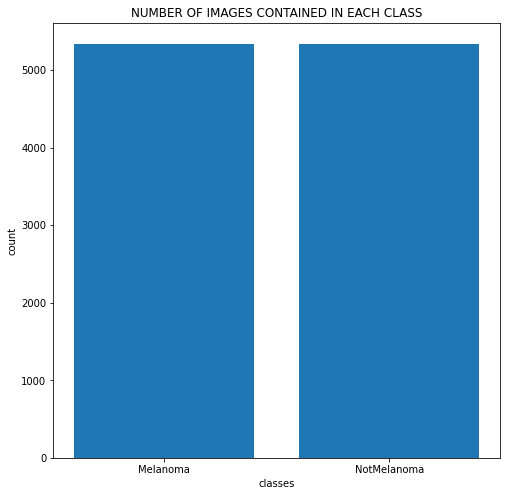

In [4]:
plt.figure(figsize = (8,8))
plt.bar(labels, num)
plt.title('NUMBER OF IMAGES CONTAINED IN EACH CLASS')
plt.xlabel('classes')
plt.ylabel('count')
plt.show()


In [5]:
x_data =[]
y_data = []
import cv2
for label in labels:
    path = '../input/melanoma/DermMel/train_sep/{0}/'.format(label)
    folder_data = os.listdir(path)
    for image_path in folder_data:
        image = cv2.imread(path+image_path,cv2.IMREAD_COLOR)
        image_resized = cv2.resize(image, (64,64))
        x_data.append(np.array(image_resized))
        y_data.append(label)

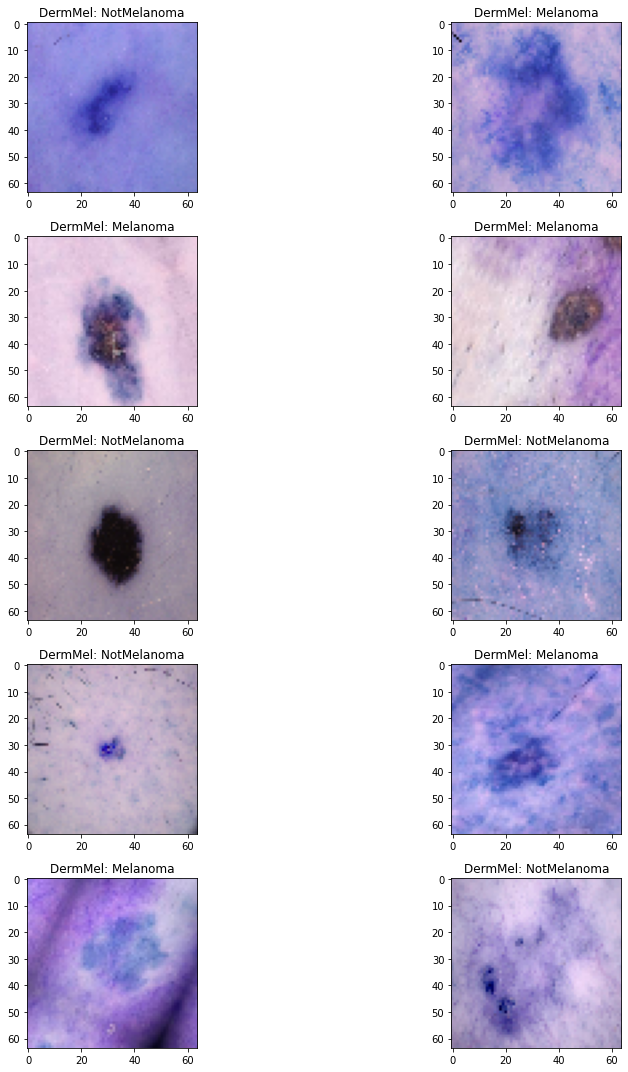

In [6]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(y_data))
        ax[i,j].imshow(x_data[l])
        ax[i,j].set_title('DermMel: '+y_data[l])
        
plt.tight_layout()

In [7]:
x_data = np.array(x_data)

y_data = np.array(y_data)

print('the shape of X is: ', x_data.shape, 'and that of Y is: ', y_data.shape)


the shape of X is:  (10682, 64, 64, 3) and that of Y is:  (10682,)


In [8]:
le=LabelEncoder()
Y=le.fit_transform(y_data)
Y=to_categorical(Y,2)
x_data = x_data/255   #standarization 
Y.shape

(10682, 2)

In [9]:
from tensorflow.keras.applications import ResNet50
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

print(conv_base.summary())

2022-01-16 07:33:31.037641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-16 07:33:31.123921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-16 07:33:31.124695: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-16 07:33:31.125859: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
__________________________

In [10]:
model = Sequential()

# model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (64,64,3)))

# model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',activation ='relu'))

# model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "sigmoid"))


In [11]:
# Making the conv_base NOT trainable:

for layer in conv_base.layers[:]:
    layer.trainable = False


In [12]:
model.compile(optimizer = Adam(learning_rate=0.001),
              loss='binary_crossentropy',metrics=['acc'])


In [13]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 25,685,634
Trainable params: 2,097,922
Non-trainable params: 23,587,712
____________________________________

In [14]:
test_label = os.listdir('../input/melanoma/DermMel/valid')
print(test_label)

['Melanoma', 'NotMelanoma']


In [15]:
x_test =[]
y_test = []

for label in test_label:
    path = '../input/melanoma/DermMel/valid/{0}/'.format(label)
    folder_data = os.listdir(path)
    for image_path in folder_data:
        image = cv2.imread(path+image_path,cv2.IMREAD_COLOR)
        image_resized = cv2.resize(image, (64,64))
        x_test.append(np.array(image_resized))
        y_test.append(label)


In [16]:
x_test = np.array(x_test)
x_test = x_test/255
y_test = np.array(y_test)
le = LabelEncoder()
y = le.fit_transform(y_test)
y = to_categorical(y,2)

In [17]:
x_test.shape,y.shape


((3562, 64, 64, 3), (3562, 2))

In [18]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='auto')


In [19]:
History = model.fit(x_data,Y,epochs = 100, validation_data = (x_test,y),
                    verbose = 1,callbacks=[early_stop])


2022-01-16 07:34:22.064180: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-01-16 07:34:25.541870: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


334/334 [==============================] - 17s 26ms/step - loss: 0.6535 - acc: 0.6288 - val_loss: 0.6237 - val_acc: 0.6297
Epoch 2/100
334/334 [==============================] - 7s 22ms/step - loss: 0.6115 - acc: 0.6754 - val_loss: 0.5859 - val_acc: 0.7333
Epoch 3/100
334/334 [==============================] - 8s 24ms/step - loss: 0.5812 - acc: 0.7022 - val_loss: 0.5624 - val_acc: 0.7392
Epoch 4/100
334/334 [==============================] - 7s 22ms/step - loss: 0.5689 - acc: 0.7143 - val_loss: 0.5301 - val_acc: 0.7302
Epoch 5/100
334/334 [==============================] - 7s 22ms/step - loss: 0.5548 - acc: 0.7182 - val_loss: 0.5357 - val_acc: 0.7611
Epoch 6/100
334/334 [==============================] - 7s 21ms/step - loss: 0.5407 - acc: 0.7326 - val_loss: 0.5074 - val_acc: 0.7762
Epoch 7/100
334/334 [==============================] - 7s 22ms/step - loss: 0.5452 - acc: 0.7306 - val_loss: 0.5106 - val_acc: 0.7673
Epoch 8/100
334/334 [==============================] - 8s 23ms/step - los

In [20]:
datagen = ImageDataGenerator(
        rotation_range=90,
        featurewise_center=True,
        featurewise_std_normalization=True,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

datagen.fit(x_data)

val_datagen = ImageDataGenerator(
        rotation_range=90,
        featurewise_center=True,
        featurewise_std_normalization=True,
         width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

val_datagen.fit(x_test)


In [21]:
History = model.fit_generator(datagen.flow(x_data,Y, batch_size=32),
                              epochs = 100, validation_data = val_datagen.flow(x_test,y,batch_size=32),
                              verbose = 1, steps_per_epoch=x_data.shape[0] // 32,
                              callbacks=[early_stop])


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
333/333 [==============================] - 23s 62ms/step - loss: 0.9304 - acc: 0.7315 - val_loss: 0.5077 - val_acc: 0.7524
Epoch 2/100
333/333 [==============================] - 22s 65ms/step - loss: 0.4962 - acc: 0.7636 - val_loss: 0.4942 - val_acc: 0.7597
Epoch 3/100
333/333 [==============================] - 21s 63ms/step - loss: 0.4778 - acc: 0.7786 - val_loss: 0.4829 - val_acc: 0.7614
Epoch 4/100
333/333 [==============================] - 22s 65ms/step - loss: 0.4730 - acc: 0.7769 - val_loss: 0.4770 - val_acc: 0.7782
Epoch 5/100
333/333 [==============================] - 23s 68ms/step - loss: 0.4585 - acc: 0.7876 - val_loss: 0.4780 - val_acc: 0.7692
Epoch 6/100
333/333 [==============================] - 23s 68ms/step - loss: 0.4540 - acc: 0.7891 - val_loss: 0.4758 - val_acc: 0.7734
Epoch 7/100
333/333 [==============================] - 22s 65ms/step - loss: 0.4512 - acc: 0.7895 - val_loss: 0.4764 - val_acc: 0.7675
Epoch 8/100
333/333 [==============================] - 

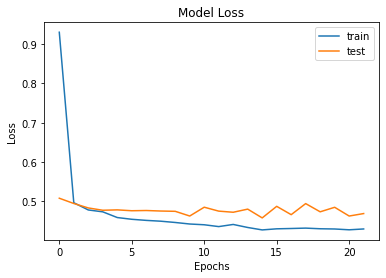

In [22]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


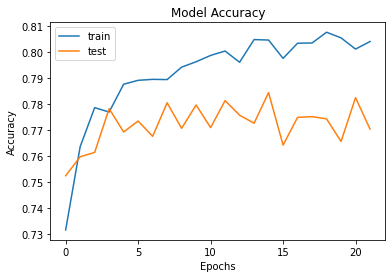

In [23]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


In [24]:
model.save('MelanomaResNet50.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
